# Explore ways of using machine learning to fit curves

The goal of this notebook is to create functions that can approximate y for a given x.

Inspired by SGD from scratch https://course.fast.ai/videos/?lesson=2 I wanted to find a single approach that would work for many different kinds of curves - i.e. I didn't want to have a linear model and a quadratic model ...

So far, I've tried
- A neural network (fastai tabular_learner)
    - which is, of course, easy to do and works really well
- A manual model that uses multiple relu(wx+b) calculations to predict y given x
    - this is just a learning excersize for me - to make something work without a library like pytorch or fastai
    
Note: I run this notebook on a GCP VM, set-up with instructions from https://course.fast.ai/index.html

In [1]:
%reload_ext autoreload
%autoreload 2
from fastai.tabular import *
# used by fastai to save models etc - make sure this is set for your environment
path = Path('/home/jupyter/my-nbs')

## Data set-up

Start by creating a couple of pandas data frames (train_df and test_def) with 2 columns each;
- x the continuous variable (i.e. the input)
- y the dependent variable (i.e. the thing we need to learn)

In [2]:
# create a dict of functions to make it easy to pick a function in the next cell
# these functions are used to generate training and test data - i.e. create an x-y curve to learn
# we should be able to use any function that has single numeric input and output values
functions = {
    'quartic': lambda x : x**4 + x**3 - 6*x**2 + x + 2,
    'cubic': lambda x : 5*x**3 - x**2 - 20*x + 3,
    'quadratic': lambda x : x**2 - 0.2*x - 3,
    'linear': lambda x : 0.25*x + 0.15,
}

         0       1        2       3       4
x   -3.500   -3.40   -3.300   -3.20  -3.100
y -153.625 -137.08 -121.575 -107.08 -93.565


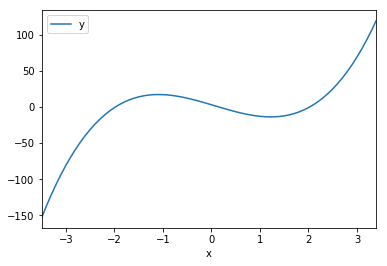

In [3]:
# set the range of the x axis
x_range = (-3.5, 3.5)
# pick a function to learn
f = functions['cubic']

def new_data_frame(step):
    """
    Create a new pandas data frame with x and y columns.
    Values in x will cover x_range using the specified step.
    Values in y are calculated by running the function we picked on x.
    """
    X = np.arange(x_range[0], x_range[1], step)
    Y = [f(x) for x in X]
    return pd.DataFrame({'x': X, 'y': Y})

# create a data frame of training data
train_df = new_data_frame(step=0.1)
# create a data frame of test data - using a different step so that not all data points in test are in train
test_df = new_data_frame(step=0.15)

# print the 1st 5 rows of the training data frame - using .T to transpose uses less vertical space in the output
print(train_df.head().T)
# plot the training data
train_df.plot(x='x', y='y')

## Set-up and train a fastai model

In [4]:
# we're using unusually small amounts of data, especially for validation - but it works OK for these experiments
data = (TabularList.from_df(train_df, path=path, cont_names=['x'], procs=[Normalize])
                .split_by_idx(range(0, len(train_df), 13))
                .label_from_df(cols='y', label_cls=FloatList)
                .add_test(TabularList.from_df(test_df, path=path, cont_names=['x']))
                .databunch())

In [5]:
# use a y range that is a bit wider than the y range in the training data
max_y = train_df['y'].max()
max_y *= 1.5 if max_y > 0 else 0.5
min_y = train_df['y'].min() 
min_y *= 1.5 if min_y < 0 else 0.5
y_range = torch.tensor([min_y, max_y], device=defaults.device)
print(y_range)

tensor([-230.4375,  179.9400], device='cuda:0')


In [6]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, y_range=y_range, metrics=mse)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


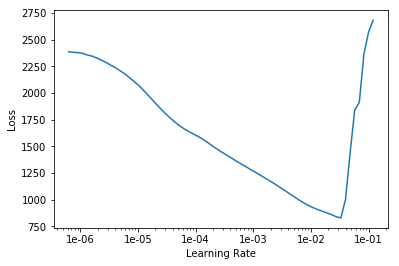

In [7]:
# lr_find usually tells us that 1e-5 would be a good learning rate
learn.lr_find()
learn.recorder.plot()

In [16]:
# we kind of ignore lr_find and use a higher learning rate - to train faster.
# we don't need to worry about overfitting, so high lr is OK and we probably don't need any weight decay either.

# 75 epochs gets quadratic pretty close
# 150 epochs gets quartic pretty close
learn.fit_one_cycle(5, 1e-03, wd=0.001)

epoch,train_loss,valid_loss,mean_squared_error,time
0,9.149093,165.783295,165.783295,00:00
1,10.842209,187.325058,187.325058,00:00
2,14.068985,154.233841,154.233841,00:00
3,12.507102,138.292877,138.292877,00:00
4,12.329984,125.725708,125.725708,00:00


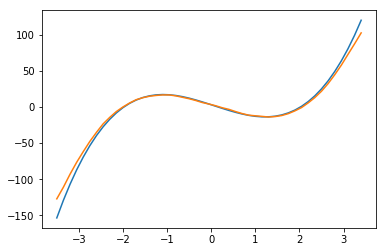

In [17]:
# get predictions from our model using the test data set
predictions, labels = learn.get_preds(DatasetType.Test)
plt.plot(test_df['x'], test_df['y'])
plt.plot(test_df['x'], predictions.squeeze()) # TODO: why do we need to squeeze? is this getting 1 batch of predictions
plt.show()

If you see flat lines at y min or max in the above prediction, try making the y range wider

# Set-up and train a "manual" model

In [12]:
class BasicLearner:
    """
    A learner that uses multiple relu(wx+b) calculations to predict y given x.
    """
    def __init__(self, train_df, number_of_weights):
        """
        Set-up the weights and biases with zeros, rather than the more standard random values,
        then save a reference to the training data.
        """
        self.weights = np.zeros(number_of_weights)
        self.biases = np.zeros(number_of_weights)
        self.train_df = train_df
        
    def mse(self, predicted_values, actual_values):
        """
        Simple mean squared error which compares a list of predicted values with a list of target values.
        """
        result = 0;
        for predicted_value, actual_value in zip(predicted_values, actual_values):
            result += (predicted_value - actual_value)**2
        return result / len(actual_values)
        
    def predict(self):
        """
        Return a list of predicted values for this learner - using weights, biases and train data.
        """
        predicted_values = []
        for x in self.train_df['x']:
            predicted_value = 0
            # for each x value, give every weight and bias a chance to contribute to the prediction
            for i, weight in enumerate(self.weights):
                # this is just relu(wx+b)
                next_bit = max(0, weight*x + self.biases[i])
                # alternate between adding and subtracting the next bit
                # doen't feel quite right - but without it, we can't curve in both directions
                if (i%2 == 0):
                    predicted_value += next_bit
                else:
                    predicted_value -= next_bit
            predicted_values.append(predicted_value)
        return predicted_values
    
    def loss(self):
        """
        Calculate the current loss on this learner - using weights, biases and train data.
        """
        return self.mse(self.predict(), train_df['y'])
    
    def update_parameter(self, i, lr, parameters, current_loss):
        """
        Increase or decrease a single parameter - only if the change reduces the loss.
        Note: we're not using gradient descent - we just update a param and see how the loss changes.
        """
        # save the value of the paramter that we might change
        parameter = parameters[i]
        # work out how much to change the parameter by
        # limit the max change we'll make to a param - this affects params with large values
        parameter_change = max(lr / 3, parameter * lr)
        # try increasing the parameter value
        parameters[i] += parameter_change
        next_loss = self.loss()
        if next_loss < current_loss:
            # if increasing this param reduced the loss, we are done
            return next_loss
        # try decreasing the parameter value
        parameters[i] -= parameter_change * 2
        next_loss = self.loss()
        if next_loss < current_loss:
            # if decreasing this param reduced the loss, we are done
            return next_loss
        # changing this parameter did not reduce the loss - put it back to its initial value
        parameters[i] = parameter
        return current_loss
    
    def learn(self, epochs, lr):
        """
        This is the learning loop.
        """
        for epoch in range(epochs):
            # calculate the loss at the start of each epoch
            pre_epoch_loss = self.loss()
            # and use this as our current loss
            current_loss = pre_epoch_loss
            for i, weight in enumerate(self.weights):
                # try updating each weight/bias 
                current_loss = self.update_parameter(i, lr, self.weights, current_loss)
                current_loss = self.update_parameter(i, lr, self.biases, current_loss)
            print('end of epoch', epoch, 'pre_epoch_loss', pre_epoch_loss, 'current_loss', current_loss)
            if pre_epoch_loss <= current_loss + (lr / 5):
                print('stopping early. current_loss is not much less than pre_epoch_loss')
                break

end of epoch 0 pre_epoch_loss 2260.0206639285843 current_loss 1084.4040925000045
end of epoch 1 pre_epoch_loss 1084.4040925000045 current_loss 776.9133210714332
end of epoch 2 pre_epoch_loss 776.9133210714332 current_loss 663.9246639285759
end of epoch 3 pre_epoch_loss 663.9246639285759 current_loss 583.9594210714329
end of epoch 4 pre_epoch_loss 583.9594210714329 current_loss 505.67397821428966
end of epoch 5 pre_epoch_loss 505.67397821428966 current_loss 439.7736353571466
end of epoch 6 pre_epoch_loss 439.7736353571466 current_loss 395.4631925000038
end of epoch 7 pre_epoch_loss 395.4631925000038 current_loss 347.5969210714321
end of epoch 8 pre_epoch_loss 347.5969210714321 current_loss 304.92222107143135
end of epoch 9 pre_epoch_loss 304.92222107143135 current_loss 263.8818353571455
end of epoch 10 pre_epoch_loss 263.8818353571455 current_loss 215.05836392857407
end of epoch 11 pre_epoch_loss 215.05836392857407 current_loss 197.7066639285741
end of epoch 12 pre_epoch_loss 197.706663

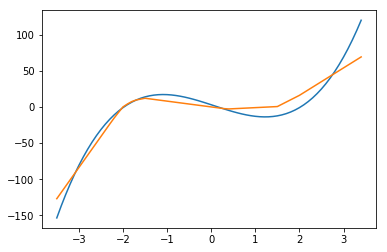

end of epoch 0 pre_epoch_loss 176.31340678571695 current_loss 159.23322678571606
end of epoch 1 pre_epoch_loss 159.23322678571606 current_loss 144.99603055714465
end of epoch 2 pre_epoch_loss 144.99603055714465 current_loss 134.4705650714304
end of epoch 3 pre_epoch_loss 134.4705650714304 current_loss 123.79421168914457
end of epoch 4 pre_epoch_loss 123.79421168914457 current_loss 119.83134489085883
end of epoch 5 pre_epoch_loss 119.83134489085883 current_loss 115.6634942251445
end of epoch 6 pre_epoch_loss 115.6634942251445 current_loss 111.40777640342299
end of epoch 7 pre_epoch_loss 111.40777640342299 current_loss 107.73849994556576
end of epoch 8 pre_epoch_loss 107.73849994556576 current_loss 103.96975185345151
end of epoch 9 pre_epoch_loss 103.96975185345151 current_loss 101.26717971679439
end of epoch 10 pre_epoch_loss 101.26717971679439 current_loss 97.9320633388515
end of epoch 11 pre_epoch_loss 97.9320633388515 current_loss 95.40141021554433
end of epoch 12 pre_epoch_loss 95.4

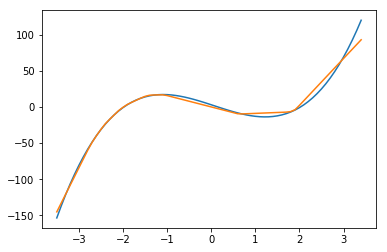

end of epoch 0 pre_epoch_loss 32.97407287365352 current_loss 31.805724795704204
end of epoch 1 pre_epoch_loss 31.805724795704204 current_loss 31.103766618432417
end of epoch 2 pre_epoch_loss 31.103766618432417 current_loss 30.4427583012845
end of epoch 3 pre_epoch_loss 30.4427583012845 current_loss 29.80463295107303
end of epoch 4 pre_epoch_loss 29.80463295107303 current_loss 29.187588473429045
end of epoch 5 pre_epoch_loss 29.187588473429045 current_loss 28.64632409236431
end of epoch 6 pre_epoch_loss 28.64632409236431 current_loss 28.09370602416385
end of epoch 7 pre_epoch_loss 28.09370602416385 current_loss 27.58614993937707
end of epoch 8 pre_epoch_loss 27.58614993937707 current_loss 27.09221160838815
end of epoch 9 pre_epoch_loss 27.09221160838815 current_loss 26.635642904260237
end of epoch 10 pre_epoch_loss 26.635642904260237 current_loss 26.20595947408646
end of epoch 11 pre_epoch_loss 26.20595947408646 current_loss 25.800972655696633
end of epoch 12 pre_epoch_loss 25.800972655

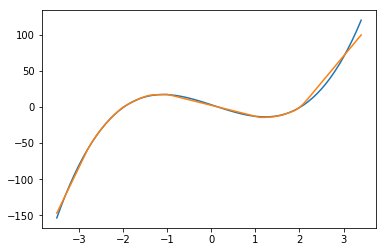

In [13]:
# create a new learner 
basic_learner = BasicLearner(train_df, number_of_weights=32)
# and do 3 rounds of learning
for i in range(3):
    # use a lower learning rate for later rounds
    basic_learner.learn(100, 3 / 10**i)
    # print the weights and biases that have been learned
    print(basic_learner.weights)
    print(basic_learner.biases)
    # plot target values against predicted at the end of each round
    predicted = basic_learner.predict()
    plt.plot(train_df['x'], train_df['y'])
    plt.plot(train_df['x'], predicted)
    plt.show()

In [ ]:
# show the predicted curve on it's own
plt.plot(train_df['x'], predicted)
plt.show()